In [5]:
## We use graphlab (aka Turi) to tune hyperparameters and train models
import turicreate as gl
import turicreate.aggregate as agg
import sys
import pickle   ## Used for saving models

## We use pandas, numpy and scipy for data analysis
import pandas as pd
import numpy as np
import scipy.stats.stats as stats
%load_ext rpy2.ipython
from math import sqrt

## sklearn is used for setting up cross validation data sets
import itertools
from collections import Counter
from sklearn import metrics, preprocessing, datasets   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Performing grid search
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
#from sklearn.cross_validation import LeaveOneLabelOut

## Matplotlib for graphing
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 8


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
## Read in data
## Set your own working directory ## 
data_1per =  gl.SFrame.read_csv('data/dmsTraining_2017-02-20.csv',column_type_hints={'aa1_psic':float, 'aa2_psic':float, 'delta_psic':float, 
                                                        'accessibility': float, 'delta_solvent_accessibility':float,
                                                        'mut_mut_msa_congruency':float})

Finished parsing file /home/alex/eth/seminar/data/dmsTraining_2017-02-20.csv

Parsing completed. Parsed 100 lines in 0.460191 secs.

Finished parsing file /home/alex/eth/seminar/data/dmsTraining_2017-02-20.csv

Parsing completed. Parsed 30268 lines in 0.344009 secs.

In [7]:
## Filter data by dataset, missense only and assign IDs to each row
data_1per = data_1per.filter_by([x for x in data_1per['dms_id'].unique() if x not in ['CcdB','beta-lactamase_2500', 'beta-lactamase_0', 
                                                                                      'kka2_1:1','kka2_1:4','kka2_1:8',
                                                                     'beta-lactamase_39', 'gal4','hemagglutinin', 'np',
                                                                                      'dbr1', 'beta-lactamase_156',
                                                                                      'beta-lactamase_625', 'ERK2', 
                                                                                      'Brca1_HDR','GFP', 'Brca1_E3',
                                                                                      'E3_ligase','Brca1_Y2H']], 'dms_id')
data_1per2 = data_1per.filter_by([x for x in data_1per['mut_type'].unique() if x in ['missense']], 'mut_type')
del data_1per2['id']
data_1per2 = data_1per2.add_row_number('id',0)

In [8]:
## Define feature set
predictors3 = ['aa1', 'aa2', 'wt_mut', 'aa1_polarity', 
               'aa2_polarity', 'aa1_PI', 'aa2_PI', 'deltaPI', 
               'Grantham', 'aa1_weight', 'aa2_weight', 'deltaWeight',
               'aa1vol', 'aa2vol', 'deltavolume', 'aa1_psic',
               'aa2_psic', 'delta_psic',  'accessibility',
               'dssp_sec_str', 'phi_psi_reg', 'delta_solvent_accessibility',
               'b_factor', 'mut_msa_congruency', 'mut_mut_msa_congruency', 
               'seq_ind_closest_mut', 'evolutionary_coupling_avg']

In [26]:
### Create Leave-one-protein-out folds
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut
folds = LeaveOneGroupOut()
lopo_folds = []
for train, test in folds.split(data_1per2, groups=data_1per2['protein']):
    lopo_folds.append((data_1per2.filter_by(train,'id'), data_1per2.filter_by(test,'id')))

In [27]:
### Define Tuning parameters
params = dict([('target', 'scaled_effect1'), ('max_depth', 5), ('max_iterations' , [25,50,100]), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , 1), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [28]:
params1 = dict([('target', 'scaled_effect1'), ('max_depth', [2, 6, 10, 25, 50] ), ('max_iterations' , 100), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' , [2, 6, 10, 25, 50]), 
               ('min_loss_reduction' , 0), ('step_size' , 0.1), ('features' , [predictors3])])

In [29]:
params2 = dict([('target', 'scaled_effect1'), ('max_depth',6), ('max_iterations' , 100), 
               ('column_subsample' , .8), ('row_subsample' , .8), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' , [0.5,0.6,0.7,0.8,0.9,1]), ('step_size' , 0.1), ('features' , [predictors3])])

In [30]:
params3 = dict([('target', 'scaled_effect1'), ('max_depth',6), ('max_iterations' , 100), 
               ('column_subsample' , [0.6, 0.7, 0.8, 0.9]), ('row_subsample' , [0.6, 0.7, 0.8, 0.9]), ('min_child_weight' ,50 ), 
               ('min_loss_reduction' ,  0.5), ('step_size' , 0.1), ('features' , [predictors3])])

In [31]:
# Parameter search with VEG selected features
lopo_train_params1 = gl.model_parameter_search.grid_search.create(lopo_folds, gl.boosted_trees_regression.create, params3)

AttributeError: module 'turicreate' has no attribute 'model_parameter_search'

In [ ]:
# Identify optimal tuning parameters
lopo_train_params1.get_best_params()

In [32]:
## Train final global model with 5-fold more trees and 0.01 learning rate
global_regression_model_noSELCO = gl.boosted_trees_regression.create(data_1per2, 'scaled_effect1', 
                features = predictors3, max_iterations = 500, 
                column_subsample= 0.6, row_subsample =0.9,
                min_child_weight = 50, min_loss_reduction = 0.5, step_size = 0.01,
                max_depth = 6)


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 19974

Number of features          : 27

Number of unpacked features : 27

+-----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 1         | 0.038250     | 1.088983           | 1.013705             | 0.427162                        | 0.431425                          |

| 2         | 0.073198     | 1.084389           | 1.010704             | 0.424419                        | 0.428707                          |

| 3         | 0.109420     | 1.080131           | 1.007040             | 0.421628                        | 0.425913                          |

| 4         | 0.147148     | 1.075579           | 1.002518             | 0.418900                        | 0.423172                          |

| 5         | 0.178799     | 1.071261           | 0.998621             | 0.416327                        | 0.420622                          |

| 10        | 0.304509     | 1.051625           | 0.980593             | 0.403883                        | 0.408246                          |

| 50        | 1.324441     | 1.008718           | 0.867015             | 0.326104                        | 0.331526                          |

| 100       | 2.622296     | 1.085845           | 0.873662             | 0.271302                        | 0.278151                          |

| 200       | 5.182213     | 1.151607           | 0.896960             | 0.227225                        | 0.236163                          |

| 300       | 7.665948     | 1.172029           | 0.889270             | 0.211866                        | 0.221675                          |

| 400       | 10.049608    | 1.176075           | 0.885682             | 0.205091                        | 0.215745                          |

| 500       | 12.465171    | 1.176587           | 0.883963             | 0.201035                        | 0.212307                          |

+-----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

In [33]:
## Save the models w/ pickle
# pickler = gl._gl_pickle.GLPickler(filename = 'models/global_regression_model_NOSELCO_selectDMS_update_2017-02-09')
# pickler.dump(global_regression_model_noSELCO)
# pickler.close()

AttributeError: module 'turicreate' has no attribute '_gl_pickle'

In [ ]:
# Use unpickle to re-open models 
# unpickler = gl._gl_pickle.GLUnpickler(filename = 'models/global_regression_model_NOSELCO_selectDMS_update_2017-02-09')
# global_regression_model_noSELCO = unpickler.load()
# unpickler.close()

In [34]:
# Use model to predict training data w/ Pearson and Spearman methods
predictions = global_regression_model_noSELCO.predict(data_1per2)
stats.pearsonr(predictions, data_1per2['scaled_effect1'])
#stats.spearmanr(predictions, data_1per2['scaled_effect1'])

/tmp/ipykernel_62891/887672950.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.pearsonr(predictions, data_1per2['scaled_effect1'])


PearsonRResult(statistic=0.7927275362601048, pvalue=0.0)

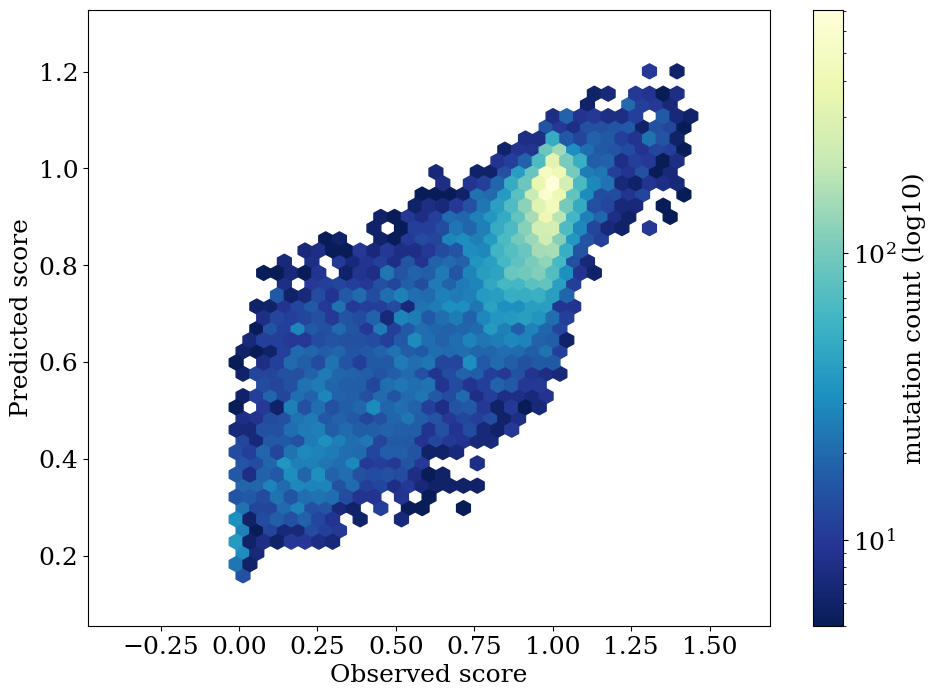

/tmp/ipykernel_62891/4065648345.py:18: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.pearsonr(predictions,data_1per2['scaled_effect1'])


PearsonRResult(statistic=0.7927275362601048, pvalue=0.0)

In [111]:
import matplotlib
predictions = global_regression_model_noSELCO.predict(data_1per2)
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)
ax.set_xlabel('Observed score')
ax.set_ylabel('Predicted score')
ax.set_ylim([-0.2,1.6])
ax.set_xlim([0,1.6])
pic = ax.hexbin(data_1per2['scaled_effect1'],predictions,norm=matplotlib.colors.LogNorm(),cmap='YlGnBu_r',gridsize=45,mincnt= 5)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
cb = plt.colorbar(pic)
cb.set_label('mutation count (log10)')
plt.rc('font', **font)
ax.axis('tight')
plt.show()
stats.pearsonr(predictions,data_1per2['scaled_effect1'])


# Validation

In [36]:
## Use Envision to predict TP53
mutagenesisSets = gl.SFrame.read_csv('data/mutagenesisSet_annotated.csv', 
                                     column_type_hints={'aa1_psic':float, 'aa2_psic':float, 'delta_psic':float, 
                                                        'accessibility': float, 'delta_solvent_accessibility':float,
                                                        'mut_mut_msa_congruency':float})

Finished parsing file /home/alex/eth/seminar/data/mutagenesisSet_annotated.csv

Parsing completed. Parsed 100 lines in 0.174946 secs.

These column type hints were not used: X1

Finished parsing file /home/alex/eth/seminar/data/mutagenesisSet_annotated.csv

Parsing completed. Parsed 8704 lines in 0.092289 secs.

In [37]:
## Make predictions
predictions = global_regression_model_noSELCO.predict(mutagenesisSets)

In [63]:
## Add predictions to dataframe
predictions1 = gl.SFrame(predictions)
predictions1 = predictions1.rename({'X1': 'global_model_predictions'})
mutagenesisSets_predictions = mutagenesisSets.add_column(predictions1['global_model_predictions'])

In [64]:
## Filter out TP53 data set
tp53 = mutagenesisSets_predictions.filter_by([x for x in mutagenesisSets_predictions['Protein'].unique() if x in ['TP53']], 'Protein')
tp53['Activity']=pd.to_numeric(tp53['Activity'])

## New Validation

Code above was adjusted from the original repo https://github.com/FowlerLab/Envision2017 

Code below is a custom validation using ROC instead of correlation

In [55]:
tp53['effect_numeric'].to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
tp53['snap2score_normalized'] = (tp53['SNAP2_score']) + 100 / 200
tp53['effect_numeric'] = (tp53['effect'] == 'damaging')
tp53

X1,X,Protein,uniprot_id,mutation,id,Activity,effect,effect2,aa1,aa2,pos,SNAP2_class
4378,4378,TP53,P04637,E2A,P04637_2,131,other,None,E,A,2,other
4379,4379,TP53,P04637,E2D,P04637_2,99,other,None,E,D,2,other
4380,4380,TP53,P04637,E2G,P04637_2,92,other,None,E,G,2,other
4381,4381,TP53,P04637,E2K,P04637_2,145,other,None,E,K,2,other
4382,4382,TP53,P04637,E2Q,P04637_2,131,other,None,E,Q,2,other
4383,4383,TP53,P04637,E2V,P04637_2,133,other,None,E,V,2,other
4384,4384,TP53,P04637,E3A,P04637_3,112,other,None,E,A,3,other
4385,4385,TP53,P04637,E3D,P04637_3,103,other,None,E,D,3,other
4386,4386,TP53,P04637,E3G,P04637_3,80,other,None,E,G,3,other
4387,4387,TP53,P04637,E3K,P04637_3,127,other,None,E,K,3,other


In [98]:
from sklearn.metrics import roc_curve,roc_auc_score

snap2_fpr, snap2_tpr, snap2_thresholds = roc_curve(tp53['effect_numeric'].to_numpy(), tp53['snap2score_normalized'].to_numpy())
snap2_auc = roc_auc_score(tp53['effect_numeric'].to_numpy(), tp53['snap2score_normalized'].to_numpy())
print('Snap2 AUC: %.3f' % snap2_auc)

Snap2 AUC: 0.833


In [90]:
envision_predictions_column = 'X45'
# normalize to [0, 1] where 0 means no effect, 1 means loss of pathgenicity
pred = tp53[envision_predictions_column]
tp53['envision_predictions_normalized'] = 1 - (pred - pred.min()) / (pred.max() - pred.min())

In [99]:
envision_fpr, envision_tpr, envision_thresholds = roc_curve(tp53['effect_numeric'].to_numpy(), tp53['envision_predictions_normalized'].to_numpy())
envision_auc = roc_auc_score(tp53['effect_numeric'].to_numpy(), tp53['envision_predictions_normalized'].to_numpy())
print('Envision AUC: %.3f' % envision_auc)


Envision AUC: 0.842


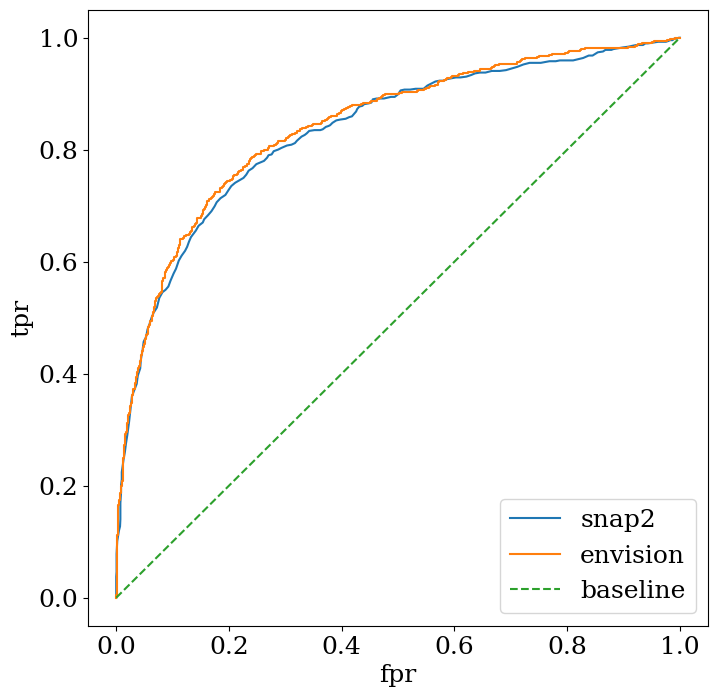

In [100]:
fig = plt.figure(figsize=(8,8))
baseline = np.linspace(0, 1, num=50)
ax = fig.add_subplot(111)
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
font = {'family': 'serif',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
ax.plot(snap2_fpr, snap2_tpr, label='snap2')
ax.plot(envision_fpr, envision_tpr, label='envision')
ax.plot(baseline, baseline, '--', label='baseline')
plt.legend()

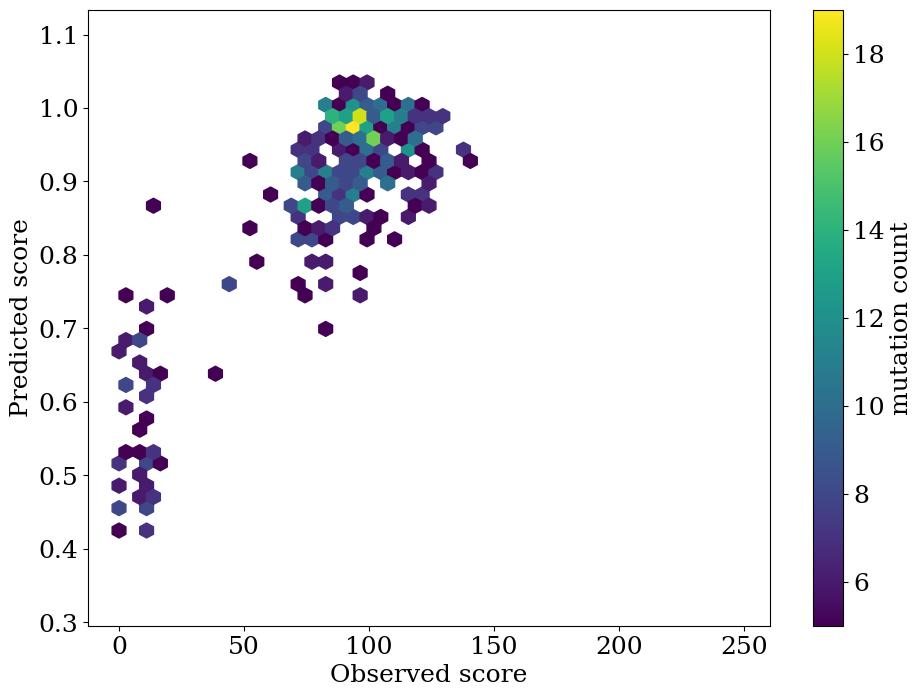

/tmp/ipykernel_62891/2258043685.py:16: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.pearsonr(tp53['Activity'], pred)


PearsonRResult(statistic=0.5841982075251015, pvalue=1.1140389959296911e-211)

In [118]:
predictions = tp53['X45']
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)
ax.set_xlabel('Observed score')
ax.set_ylabel('Predicted score')
pic = ax.hexbin(tp53['Activity'],predictions,gridsize=45,mincnt= 5)
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
cb = plt.colorbar(pic)
cb.set_label('mutation count')
plt.rc('font', **font)
ax.axis('tight')
plt.show()
stats.pearsonr(tp53['Activity'], pred)


In [115]:
tp53['Activity'].max()

248

## Old Code

In [ ]:
## Use SNAP2 to predict TP53
stats.spearmanr(tp53['Activity'], tp53['SNAP2_score'])

In [ ]:
## Look at Envision predictive performance for each mutant amino acid (aa2)
## Predictive performance is measured with Pearson CC here
tp53.to_dataframe().groupby(['aa2'])['Activity', 'X45'].corr()

In [ ]:
## Look at Envision predictive performance for each original amino acid (aa1)
## Predictive performance is measured with Pearson CC here
tp53.to_dataframe().groupby(['aa1'])['Activity', 'X45'].corr()

In [ ]:
## Look at SNAP2 predictive performance for each mutant amino acid (aa2)
## Predictive performance is measured with Pearson CC here
tp53.to_dataframe().groupby(['aa2'])['Activity', 'SNAP2_score'].corr()

In [ ]:
## Look at Envision predictive performance for each original amino acid (aa1)
## Predictive performance is measured with Pearson CC here
tp53.to_dataframe().groupby(['aa1'])['Activity', 'SNAP2_score'].corr()

In [ ]:
## Figure 3D: Hexbin plot showing correlation between TP53 varian effects and 
## Envision predictions (y-axis). 

## Build the plot
ax = plt.hexbin(tp53['Activity'],tp53['X45'],
           cmap=plt.cm.YlGnBu_r,
           gridsize=20,
           bins=None,
           mincnt=5,
        vmin= 1,
               vmax = 100)        #hexbinning
                          #necessary for correct aspect ratio
## Formatting code
    plt.axis([-10, 200, 0.3, 1.05])
cb = plt.colorbar()
cb.set_label('mutation count')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.show()

## Measure correlation between predictions and TP523 with pearson and spearman CC
stats.pearsonr(tp53['Activity'], tp53['X45'])
stats.spearmanr(tp53['Activity'], tp53['X45'])

In [ ]:
## Feature importance analysis
## Use get_feature_importance function from graphlab
importance = global_regression_model_noSELCO.get_feature_importance()
importance

In [ ]:
## Treat categorical features as dummy variables
importance.groupby(key_columns=['name', 'index'], operations={'count': agg.SUM('count')}).sort('count', ascending=False).print_rows(num_rows = 25)

In [ ]:
## Ignore index when assessing feature importance
importance.groupby(key_columns=['name'], operations={'count': agg.SUM('count')}).sort('count', ascending=False).print_rows(num_rows = 25)

In [ ]:
## Use T-test to determine whether Proline mutations are significantly 
# more damaging that other amino acid variants.
result = data_1per2.to_dataframe().groupby([ 'aa2','protein'])['scaled_effect1'].mean()
result_AA = data_1per2.to_dataframe().groupby([ 'protein','aa2'])['scaled_effect1'].mean()
result2 = result.unstack()
result_AA2 = result_AA.unstack()
ave = (result2).mean()
P = result_AA2.P
stats.ttest_ind(P, ave, equal_var = False)

In [ ]:
# Mean variant effect of all amino acids
ave.mean()

In [ ]:
## Heatmap showing the mean variant effect of each amino acid for each data set
fig, ax = plt.subplots()
plt.pcolor(result2, cmap='YlGnBu',vmin=0, vmax=1)
ax.set_xticklabels(result2.axes[1], minor=False)
ax.set_yticklabels(result2.axes[0], minor=False)
ax.set_yticks(np.arange(result2.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(result2.shape[1]) + 0.5, minor=False)
plt.xticks(rotation='vertical')
plt.colorbar()
plt.show()

In [ ]:
## Predict proline mutations from each DMS and calc Pearson's R
P = data_1per2.filter_by([x for x in data_1per2['aa2'].unique() if x in ['P']], 'aa2')
predictions = global_regression_model_noSELCO.predict(P)
predictions1 = gl.SFrame(predictions)
predictions1.rename({'X1': 'Envision_predictions'})
P2 = P.add_column(predictions1['Envision_predictions'])
P2.rename({'X55': 'Envision_predictions'})

In [ ]:
## Measure Envision predictive performance for each mutant amino acid (aa2) type separately
## Method  =  Spearman
data_1per2.to_dataframe().groupby(['aa2'])['scaled_effect1', 'Envision_predictions'].corr(method = 'spearman')

In [ ]:
## Measure Envision predictive performance for each original amino acid (aa1) type separately
data_1per2.to_dataframe().groupby(['aa1'])['scaled_effect1', 'Envision_predictions'].corr()

In [ ]:
#Measure Envision performance on proline mutations from each data set
## Pearson correlation
P2.to_dataframe().groupby(['dms_id'])['scaled_effect1', 'Envision_predictions'].corr()

In [ ]:
# Measure Envision performance on proline mutations across all data sets
predictions = global_regression_model_noSELCO.predict(P2)
stats.pearsonr(predictions,P2['scaled_effect1'])

In [ ]:
## Plot Envision predictions vs. observed variant effects for proline variants

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel('Predicted proline effect')
ax.set_ylabel('Observed proline effect')
ax.set_ylim([-0.2,1.6])
ax.set_xlim([-0.2,1.6])
im = ax.scatter(predictions,P2['scaled_effect1'])
ax.axis('tight')
#cb =fig.colorbar(im, ax=ax)
#cb.set_label('Number of proline mutations (log)')
plt.show()

In [ ]:
## Read in EVmutation predictions for tp53 mutatations and make a hexbinplot
evMut_TP53 =  gl.SFrame.read_csv('~/data/EVmutation_TP53.csv')

In [ ]:
## Use pandas to format data structure
evMut_TP53['tp53']=pd.to_numeric(evMut_TP53['tp53'])

In [ ]:
## Measure correlation between TP53 observed variant effects and EVmutation - epistatic 
# predictions w/ Spearman algorithm
stats.spearmanr(evMut_TP53['tp53'], evMut_TP53['prediction_epistatic'], nan_policy = 'omit' )

In [ ]:
## Measure correlation between TP53 observed variant effects and EVmutation - independent 
# predictions w/ Spearman algorithm
stats.spearmanr(evMut_TP53['tp53'], evMut_TP53['prediction_independent'], nan_policy = 'omit' )

In [ ]:
## For each original amino acid (wt) type, measure correlation between TP53 observed 
#variant effects and EVmutation - independent predictions w/ Spearman algorithm
evMut_TP53.to_dataframe().groupby(['wt'])['tp53', 'prediction_independent'].corr()

In [ ]:
## For each mutant amino acid (subs) type, measure correlation between TP53 observed 
#variant effects and EVmutation - independent predictions w/ Pearson algorithm
evMut_TP53.to_dataframe().groupby(['subs'])['tp53', 'prediction_independent'].corr()

In [ ]:
## For each mutant amino acid (subs) type, measure correlation between TP53 observed 
#variant effects and EVmutation - epistatic predictions w/ Spearman algorithm
evMut_TP53.to_dataframe().groupby(['subs'])['tp53', 'prediction_epistatic'].corr(method='spearman')

In [ ]:
## For each original amino acid (wt) type, measure correlation between TP53 observed 
#variant effects and EVmutation - epistatic predictions w/ Spearman algorithm
evMut_TP53.to_dataframe().groupby(['wt'])['tp53', 'prediction_epistatic'].corr(method='spearman')